# Omnifocus imaging using lens swivel (simulation in Zemax)

## Preface

This notebook documents the Zemax-based simulations that verify our theory for synthesizing omnifocus image as proposed in the paper "*Omnifocus image synthesis using lens swivel*," I. Sinharoy, P. Rangarajan, 
and M. Christensen, Imaging and Applied Optics 2016, OSA.

The simulations are carried out using Zemax. In addition the PyZDDE toolbox is used to automate the processing, setting the appropriate parameters in Zemax, and running the image simulation multiple times.

*Repository @ Github: [cosi2016_omnifocus](https://github.com/indranilsinharoy/cosi2016_omnifocus)*

**Note**

The following Scientific Python Libraries are required:
1. Numpy
2. Scipy
3. IPython
4. Matplotlib
5. h5py
6. PyZDDE
7. OpenCV

Additionally, for most part of the notebook a <mark>running Zemax/Opticstudio instance is expected</mark>.


In [1]:
# Import libraries
from __future__ import division, print_function
import os
import gc
import shutil
import numpy as np
from scipy.misc import imread, imsave
import scipy.ndimage as ndi
import h5py as hdf
import matplotlib.pyplot as plt
from IPython.core import display
from ipywidgets import widgets
from ipywidgets import interactive, interact 
import cv2

# PyZDDE 
import pyzdde.zdde as py

# Local module of helper functions
import omnifocuslib as oflib

In [2]:
%matplotlib inline
#%matplotlib notebook

In [3]:
# location of the Zemax files
curDir = os.getcwd()
zmxdir = os.path.join(curDir, 'zmxfiles')

In [4]:
# Create data directory at if not already present
oflib.get_directory_path(['data', 'imgstack']);

Download the following HDF5 files containing the stacks from simulations used for the paper (only required to do once). 

Please download to `.\data\imgstack` by clicking on the following hyperlinks:


1. [fronto_para_focal_stack_2016_07_31_02_10.h5py](https://dl.dropboxusercontent.com/u/20104715/github/cosi2016_omnifocus/fronto_para_focal_stack_2016_07_31_02_10.hdf5) (~65 MB)
2. [lens_tilt_focal_stack_2016_03_21_02_19.hdf5](https://dl.dropboxusercontent.com/u/20104715/github/cosi2016_omnifocus/lens_tilt_focal_stack_2016_03_21_02_19.hdf5) (~704 MB)


In [5]:
# instantiate a PyZDDE link
ln = pyz.createLink()

## Simulation of image capture in Zemax

### Simulation of image capture for frontoparallel focal stack using a thin lens model

We start with a simple paraxial thin lens model to create and display a frontoparallel focal stack. We use this simplified model mainly to ensure that the basic functions for automation---chaning lens parameters and triggering image simulation in Zemax via PyZDDE, creating and storing the stack in HDF5 file format, automatic detection of in-focus regions using an appropriate focus measure function (LoG), etc---are working as expected.

We will load a preconfigured lens (.zmx file) in which the cardinal planes and the entrance and exit pupils are drawn as dummy surfaces. (If you are using a new lens design please use the function `draw_pupil_cardinal_planes()` in the module <kbd>`omnifocuslib`</kbd> to insert cardinal and pupil planes as dummy surface.)

It is recommended that (at least in the beginning) experiment with the preconfigured lens. The preconfigured lens also uses a preconfigured settings files (`spl.cfg`) that contains proper image simulation settings.


In [6]:
loadStoredCopy = True
if loadStoredCopy:
    storedLens = "paraxialSingleLens24mmFiniteConj_cardinalsDrawnWdRotAbtENPP.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
else:
    ln.zGetRefresh()

The following figure shows the 3D Layout plot 3D.

In [7]:
arr = ln.ipzCaptureWindow('L3d', percent=15, gamma=0.15, retArr=True)

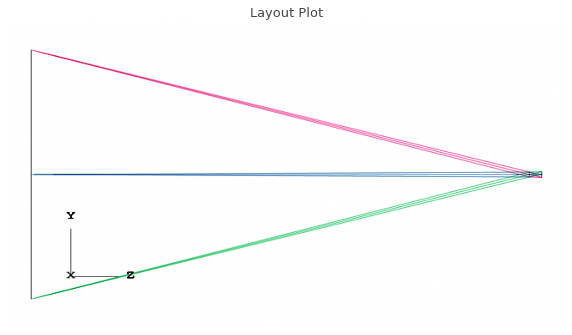

In [8]:
pyz.imshow(arr, cropBorderPixels=(5, 5, 20, 20), figsize=(10,10), title='Layout Plot')

In [9]:
# ... and the surfaces in LDE
ln.ipzGetLDE()

SURFACE DATA SUMMARY:

Surf     Type         Radius      Thickness                Glass      Diameter          Conic   Comment
 OBJ TILTSURF              -            960                                500              -
   1 STANDARD       Infinity             40                                  0              0 dummy 2 c rays
   2 STANDARD       Infinity              0                                  0              0 Move to ENPP
   3 COORDBRK              -              0                                  -              - Lens tilt CB
   4 STANDARD       Infinity              0                                  0              0 dummy
   5 STANDARD       Infinity              0                                2.4              0 H
   6 STANDARD       Infinity            -24                                  0              0 dummy
   7 STANDARD       Infinity             24                                2.4              0 F
   8 STANDARD       Infinity              0                     

#### Determine appropriate parameters for image simulation

The parameters that we need to determine for proper* image simulation are the following:

1. Field height of the source image.
2. Oversampling factor (if any required).
3. Pupil sampling.
4. Image sampling.
5. Detector pixel size.
6. Detector x-pixels and y-pixels. 

\* *an image simulation that is adequately representative of real world imaging.*


For an general overview of using the image simulation toolbox in Zemax using PyZDDE, please refer to [Acquisition and analysis of Image Simulation data from Zemax](http://nbviewer.jupyter.org/github/indranilsinharoy/PyZDDE/blob/master/Examples/IPNotebooks/04%20Acquisition%20and%20analysis%20Image%20Simulation%20data%20from%20Zemax.ipynb)

Additionally, one setting that is important from the perspective of the image simulation setup in Zemax for our problem is mentioned briefly now. 

We need to essentially simulate image formation of a 3D scene containing three planes at three different depths. However, the image simulation tool in Zemax is designed for plane to plane imaging. To get around this limitation in Zemax, we need to run image simulation three times (for the three planes) for every orientation of the lens. Following the three runs of image simulations, we *add* the three images to obtain a single image that respresents the image of the 3D scene. Also, we spatially separate the three cards in the scene not only in depth but also along the x-axis so that their images on the sensor are spatially separated when *integrated*. To speparte them spatially along the x-axis, we add two fields in the field data editor that are separated along the x-axis (in addition to the on-axis field) as shown in the following figure. Furthermore, set the "Reference" field to "Chief Ray" in the image simulation settings (shown in the next figure), and we change the "Field" number accordingly in the image simulation settings for the corresponding card in every run of the simulation. Of course, all of these are handled by the Python code in the simulation.   

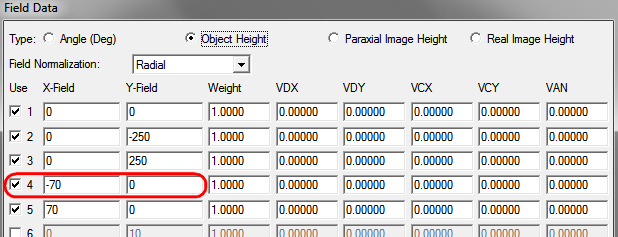

In [47]:
display.Image(filename='./images/field_specification.png')

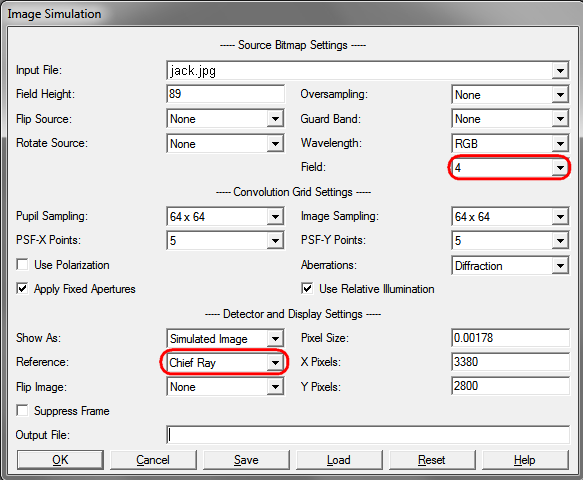

In [48]:
display.Image(filename='./images/img_simulation_setting.png')

###### Addition of Zernike Standard Phase Surface (and small amount of aberration)

We insert a Zernike Standard Phase surface co-located with the exit pupil (i.e. in the LDE, its position is just before the exit pupil surface, and its thickness set to zero). 

The Zernike Standard Phase surface serves two main purpose:

* We can systematically introduce aberrations to the baseline diffraction limited system to make the simulation more realistic.

* In Zemax image simulation, we set an appropriate pixel size to mimic a digital sensor. If the optical PSFs are too small (i.e. diffraction limited), we need to either set the object field height to a very small value and/or use oversampling in order to adequately sample the PSF. On the one hand, oversampling is a disadvantage because the simulation time increases exponentially, on the other using a miniscule object field height will not be a good representation of real world object. Yet, if we can avoid both these issues if we appropriately increase the size of the PSF by adding some amount of aberrations.    

In [10]:
# Get the surface number of the Exit Pupil
# It assumes that the exit-pupil surface has the commnet 'EXPP' 

for i in range(ln.zGetNumSurf()):
    if ln.zGetComment(i) == 'EXPP':
        break
print('Exit pupil surface number is:', i)

# Insert Zernike surface just before the exit pupil
zernSurfNum = i  # the new position of the EXPP surface will be i+1
ln.zInsertSurface(surfNum=zernSurfNum)
ln.zSetSurfaceData(surfNum=zernSurfNum, code=ln.SDAT_TYPE, value='SZERNPHA')

Exit pupil surface number is: 13


'SZERNPHA'

In [11]:
#ln.push

In [12]:
# Set Zernike surface's initial properties
maxTermCol = 1
maxTerm = 11  # upto primary spherical aberration
normRadiusCol = 2
normRadius = ln.zGetPupil().EXPD/2
priSphCol = 2 + 11   # 2 cols for maxTerm and normRadius plus 11th zernike term

ln.zSetExtra(zernSurfNum, maxTermCol, maxTerm)
ln.zSetExtra(zernSurfNum, normRadiusCol, normRadius)
# we will set the aberration terms later (depending on object field height and number of pixels)

5.0

Extract source image data and estimate simulation parameters

In [13]:
# If source bitmap image is not in the IMAFiles folder then 
# they are copied from local directory to IMA files directory
usr = os.path.expandvars("%userprofile%")
IMAdir = os.path.join(usr, 'Documents\Zemax\IMAFiles')
images = ['king.jpg', 'queen.jpg', 'jack.jpg']
imgSrcDir = os.path.join(curDir, 'images')
for image in images:
    imgfilename = os.path.join(IMAdir, image)
    if not os.path.exists(imgfilename):
        print('Copying {} to {}'.format(image, IMAdir))
        imgSrc = os.path.join(imgSrcDir, image)
        shutil.copy(imgSrc, imgfilename)
ypix, xpix, _ = imread(imgfilename).shape
        
print('Rows (y-pixels) =', ypix)
print('Cols (x-pixels) =', xpix)

Rows (y-pixels) = 1010
Cols (x-pixels) = 656


We emperically determined by tinkering in Zemax (we could also write functions to automatically determine the proper parameters) that in order to use object field height of 89.0 *mm* (physical height of standard playing cards) in the image simulation and still attain adequate sampling of the PSF, we require the pixel size (a side of square pixel) to be 0.0021668560298652812 *mm* and the Zernike standard coefficient number 11 for imparting small spherical aberration to be 0.126.

In [14]:
h = 89.0     # height of the object
ln.zSetExtra(zernSurfNum, priSphCol, 0.126)
detPixelSize, detXPixels, detYPixels = 0.0021668560298652812, 2853, 1330

In [15]:
 #ln.push

Now we will call the main image simulation function `focal_stack_fronto_parallel()`. 

In [15]:
# In the setup of the lens, it is expected that the first surface in the LDE (OBJ or 
# surfNum=0) is the object surface, following which is a dummy surface for rendering 
# incoming rays close to the lens (in physical space). Therefore, the PHYSICAL distance
# between the object surface and the vertex of the lens' left most surface is equal to
# the thickness of the OBJ surface plus the dummy surface in the LDE.

# In this particular experiment the thickness of the dummy surface was 40 mm
# 

# Settings for every composed image frame with object at 3 different depths 
# from the lens
dummySurfThick = 40    # in mm
objsurfthick = [1000-dummySurfThick, 800-dummySurfThick, 1200-dummySurfThick] 
objarr = ['king.jpg', 'queen.jpg', 'jack.jpg']
fldarr = [1, 4, 5]   # list of field numbers that are used for the corresponding 
                     # objects in `objarr` for image simulation in Zemax.
                     # Bcoz we have 3 objects that are spread along x-axis 
                     # (so that their images on the sensor are NOT coincident)
                     # we need to specify 3 fields along x-axis in the "Fields"
                     # in Zemax whose angular separation determines the 
                     # separation between the images of the 3 cards on the sensor

# settings for generation of the focal-sweep stack of images
focalLength = 24       # in mm
numOfImagesInStack = 3 #10

# function to generate the range of shifts of the image plane along the optical 
# axis relative to the base position (position at which the middle object is
# in geometrical focus)
imgDelta = oflib.get_image_plane_shifts(nearObj=800, farObj=1200, fl=focalLength, 
                                     num=numOfImagesInStack) #[-1]
if not isinstance(imgDelta, list):
    imgDelta = list((imgDelta,))


# function to generate the image stack and store in an HDF5 container

# arguments to the function zSetImageSimulationsSettings()
X2, X4, X8, X16, X32 = 1, 2, 3, 4, 5  # oversampling
RGB = 0                               # Wavelength
NOAB, GEOM, DIFF = 0, 1, 2            # Aberration
S32by32, S64by64 = 1, 2               # Pupil/Image Sampling
CHIEF, VERTEX = 0, 1                  # reference
SIMIMG, SRCBMP, PSFGRID = 0, 1, 2     # show as 

hdffileFull = oflib.focal_stack_fronto_parallel(ln, imgDelta=imgDelta, 
                                             objsurfthick=objsurfthick, 
                                             objarr=objarr, fldarr=fldarr, 
                                             objht=h, over=0, 
                                             pupsam=S32by32, imgsam=S32by32, 
                                             psfx=1, psfy=1, 
                                             pixsize=detPixelSize, 
                                             xpix=detXPixels, ypix=detYPixels, 
                                             timeout=240, verbose=True)


os.path.split(hdffileFull)[-1]

Time: 0:00:00. Starting image simulation for delta = -0.1004
Time: 0:03:30. Image sim of data type img for obj king.jpg for obj thick 960.00 completed!
Time: 0:07:08. Image sim of data type img for obj queen.jpg for obj thick 760.00 completed!
Time: 0:10:31. Image sim of data type img for obj jack.jpg for obj thick 1160.00 completed!
Time: 0:14:23. Image sim of data type img for obj imgsim_god.png for obj thick 960.00 completed!
Time: 0:18:20. Image sim of data type img for obj imgsim_god.png for obj thick 760.00 completed!
Time: 0:21:58. Image sim of data type img for obj imgsim_god.png for obj thick 1160.00 completed!
Traced for chief-ray intersects...
Time: 0:21:58. Starting image simulation for delta = 0.0000
Time: 0:25:21. Image sim of data type img for obj king.jpg for obj thick 960.00 completed!
Time: 0:28:55. Image sim of data type img for obj queen.jpg for obj thick 760.00 completed!
Time: 0:32:19. Image sim of data type img for obj jack.jpg for obj thick 1160.00 completed!
Ti

'fronto_para_focal_stack_2016_07_31_02_10.hdf5'

###### View the stack of images stored in the HDF5 file

Mags: -0.024, -0.031, -0.020


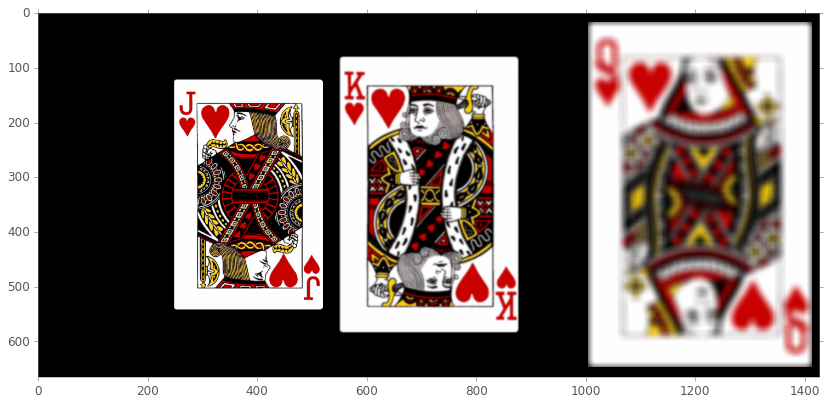

In [16]:
oflib.iSelect = None
interact(oflib.show_stack, hdffile=oflib.get_hdf5files_list(stype=0),  
         what={'Images': oflib.show_image_stack,
               'PSF Grids': oflib.show_psf_stack, 
               'CR IMG int.': oflib.show_cr_img_inter_frontoparallel_stack,});

In [17]:
gc.collect()

7277

In [18]:
#ln.close()

### Simulation of image capture for angular sweep stack using paraxial double lens model by rotating the lens about the entrance pupil

In [19]:
loadStoredCopy = True
if loadStoredCopy:
    storedLens = "paraxialDoubleLens24mmFiniteConj_mp1_cardinalsDrawnWdRotAbtENPP.zmx"
    storedLensPath = os.path.join(zmxdir, storedLens)
    ln.zLoadFile(storedLensPath)
else:
    ln.zGetRefresh()

For the purpose of this simulation I decided to not focus on any of the playing cards when the lens is not tilted (in frontoparallel configuration). In fact, I don't even think that it is necessary to capture an image of the scene in frontoparallel configuration. The variable `deltai` in the following code cell is the amount by which the sensor plane is translated along the z-axis from the potition in which the camera would have focused on the front card.

In [20]:
# To change focus from the middle surface to some other surface in plane parallel configuration

#deltai = 0.1466628      # focus on the front surface
#deltai = 0.0901633      # focus 1/3rd the distance between the first and mid surface from the first towards mid
#deltai = 0.095
#deltai = 0.2517254      # focus 100 mm infront of the first object (this will increase the maximum amount
                        # of lens rotation required) 
deltai = 0.1956346      # focus 50 mm infront of the first object ... the DOF for the previous one was a little too shallow
    
surfNum = ln.zGetNumSurf()
ln.zInsertSurface(surfNum)
ln.zSetThickness(surfNum, deltai)

0.1956346

In [21]:
# the surfaces in the lens data editor
ln.ipzGetLDE()

SURFACE DATA SUMMARY:

Surf     Type         Radius      Thickness                Glass      Diameter          Conic   Comment
 OBJ TILTSURF              -            990                                500              -
   1 STANDARD       Infinity             10                                  0              0 dummy 2 c rays
   2 STANDARD       Infinity             16                                  0              0 Move to ENPP
   3 COORDBRK              -            -16                                  -              - Lens tilt CB
   4 STANDARD       Infinity             16                                  0              0 dummy
   5 STANDARD       Infinity            -16                                2.4              0 H
   6 STANDARD       Infinity             -8                                  0              0 dummy
   7 STANDARD       Infinity              8                                2.4              0 F
   8 STANDARD       Infinity             16                     

In [22]:
#ln.push

Just like in the case of the frontoparallel simulation, we will insert a Zernike standard phase surface at the location of the exit pupil.

In [23]:
# Get the surface number of the Exit pupil. 
# It assumes that the exit pupil surface has the comment 'EXPP'

for i in range(ln.zGetNumSurf()):
    if ln.zGetComment(i) == 'EXPP':
        break
print('Exit pupil surface number is:', i)

Exit pupil surface number is: 14


In [24]:
# Insert Zernike surface at the EXPP
zernSurfNum = i  # the new position of the EXPP surface will be i+1
ln.zInsertSurface(surfNum=zernSurfNum)
ln.zSetSurfaceData(surfNum=zernSurfNum, code=ln.SDAT_TYPE, value='SZERNPHA')

'SZERNPHA'

In [25]:
#ln.push

0

In [26]:
# Set Zernike surface's initial properties
maxTermCol = 1
maxTerm = 11  # upto primary spherical aberration
normRadiusCol = 2
normRadius = ln.zGetPupil().EXPD/2
priSphCol = 2 + 11   # 2 cols for maxTerm and normRadius plus 11th zernike term

ln.zSetExtra(zernSurfNum, maxTermCol, maxTerm)
ln.zSetExtra(zernSurfNum, normRadiusCol, normRadius)
# we will set the aberration terms later

5.0

Extract source image data and estimate simulation parameters.

In [27]:
# If source bitmap image is not in the IMAFiles folder then 
# they are copied from local directory to IMA files directory
usr = os.path.expandvars("%userprofile%")
IMAdir = os.path.join(usr, 'Documents\Zemax\IMAFiles')
images = ['king.jpg', 'queen.jpg', 'jack.jpg']
imgSrcDir = os.path.join(curDir, 'images')
for image in images:
    imgfilename = os.path.join(IMAdir, image)
    if not os.path.exists(imgfilename):
        print('Copying {} to {}'.format(image, IMAdir))
        imgSrc = os.path.join(imgSrcDir, image)
        shutil.copy(imgSrc, imgfilename)
ypix, xpix, _ = imread(imgfilename).shape
        
print('Rows (y-pixels) =', ypix)
print('Cols (x-pixels) =', xpix)

Rows (y-pixels) = 1010
Cols (x-pixels) = 656


In [28]:
h = 89.0
ho = oflib.get_cardinal_points(ln).Ho

detDat = oflib.get_detector_settings(h=h, xpix=xpix, ypix=ypix, fl=24, xfield=70, 
                                  umid=ho+990, 
                                  unear=ho+790, 
                                  ufar=ho+1190)
detPixelSize, detXPixels, detYPixels = detDat
detPixelSize, detXPixels, detYPixels

(0.0017812641832943904, 3375, 1565)

**<font color='magenta'>To do!</font>**

Update the function `get_detector_settings()`. Originally this function was written for frontoparallel image capture. It doesn't account for the fact that the image field translates (vertically up or down) when the lens is rotated about the x-axis. Therefore, the function currently under-estimates the number of pixels required in the vertical direction.  

In [29]:
cb1 = 3
#detPixelSize, detXPixels, detYPixels = 0.00178, 3375, 2320  # for ±5° tilt about x
#detPixelSize, detXPixels, detYPixels = 0.00178, 3375, 2500  # for ±6° tilt about x
detPixelSize, detXPixels, detYPixels = 0.00178, 3380, 2800   # for ±8° tilt about x 

In [30]:
ln.zSetExtra(zernSurfNum, priSphCol, 0.126)

0.126

**<font color='magenta'>To do!</font>**

Function to automatically determine the appropriate tilts based on focal length, aperture setting, the required depth-of-field and the distance of the beginning of the DOF region.

In [31]:
#ln.push

0

Before we call the functions to simulate image formation under lens tilts, it is useful to have a mental picture of what is really going on in Zemax. The following image shows three (overlapped) configurations of the lens pivoted at the entrance pupil (ENPP) and tilted by -10°, 0°, and 10° about the x-axis (indicated by the blue, green and magenta lines). Thick lines show the different surfaces in the LDE---paraxial lens L1, exit pupil (EXPP), limiting aperture stop (Stop), entrance pupil (ENPP), and paraxial lens L2. The thin lines with arrows (and corresponding color) shows the chief-rays from three field points from one of the object surfaces.

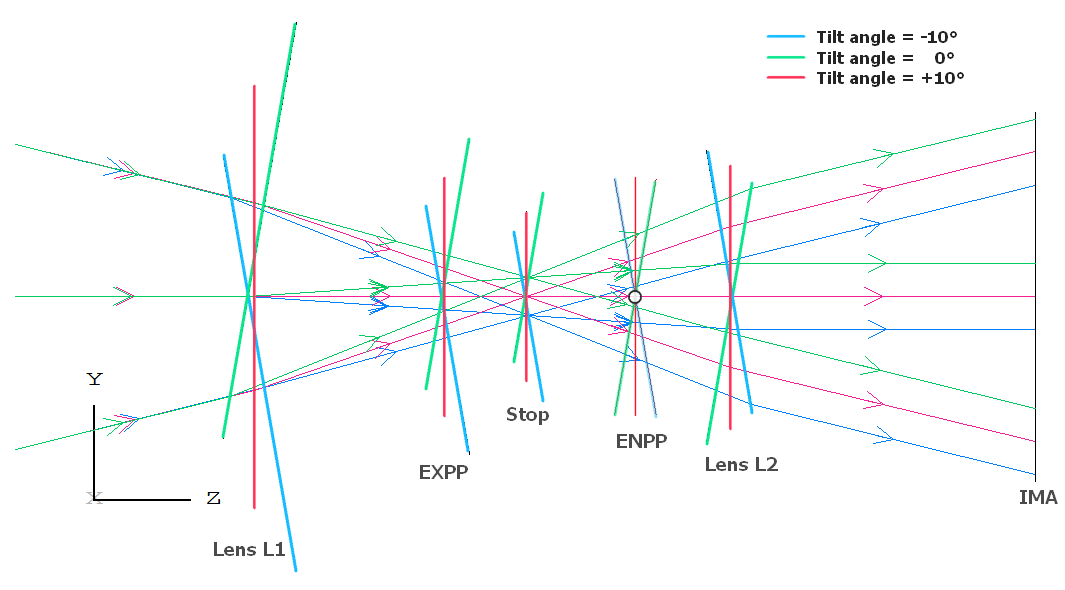

In [32]:
display.Image(filename='./images/lens_tilts_configurations.png', width=825)

In [23]:
# In the setup of the lens, it is expected that the first surface in the LDE (OBJ or 
# surfNum=0) is the object surface, following which is the dummy surface for rendering 
# incoming rays close to the lens (in physical space). Therefore the PHYSICAL distance
# between the object surface and the vertex of the lens' left most surface is equal to
# the thickness of the OBJ surface and the dummy surface in the LDE.

# Settings for every composed image frame with object at 3 different depths 
# from the lens
dummySurfThick = ln.zGetThickness(surfNum=1)

# fetch the dummySurfThick from the 

objsurfthick = [1000-dummySurfThick, 800-dummySurfThick, 1200-dummySurfThick] 
objarr = ['king.jpg', 'queen.jpg', 'jack.jpg']
fldarr = [1, 4, 5]

# settings for generation of the focal-sweep stack of images
focalLength = 24
numOfImagesInStack = 13 #15

# function to generate the range of angular shifts of the image plane along the optical 
# axis relative to the base position (position at which the middle object is
# in geometrical focus)
angDelta = oflib.get_lens_plane_tilts(uo=1000, nearObj=800, farObj=1200, fl=focalLength, 
                                     num=numOfImagesInStack) #[-1]
if not isinstance(angDelta, list):
    angDelta = list((angDelta,))

# function to generate the image stack and store in an HDF5 container

# arguments to the function zSetImageSimulationsSettings()

X2, X4, X8, X16, X32 = 1, 2, 3, 4, 5  # oversampling
RGB = 0                               # Wavelength
S32by32, S64by64 = 1, 2               # Pupil/Image Sampling
AB_NONE, AB_GEO, AB_DIFF = 0, 1, 2    # Aberration

hdffileFull = oflib.focal_stack_lens_tilts(ln, cb1=cb1, tiltX=angDelta, 
                                        objsurfthick=objsurfthick, 
                                        objarr=objarr, fldarr=fldarr, 
                                        objht=h, over=0, 
                                        pupsam=S64by64, imgsam=S64by64, 
                                        psfx=5, psfy=5, 
                                        pixsize=detPixelSize, 
                                        xpix=detXPixels, ypix=detYPixels,
                                        aberr=AB_DIFF, psfGrid=False,
                                        timeout=60*20, verbose=True)

os.path.split(hdffileFull)[-1]

TO IMPLEMENT
Time: 0:00:00. Starting image simulation for tiltAbtX = -8.0000
Time: 0:10:11. Image sim of data type img for obj king.jpg for obj thick 990.00 completed!
Time: 0:21:03. Image sim of data type img for obj queen.jpg for obj thick 790.00 completed!
Time: 0:30:55. Image sim of data type img for obj jack.jpg for obj thick 1190.00 completed!
Traced chief-ray intersects.
Time: 0:31:08. Starting image simulation for tiltAbtX = -6.6667
Time: 0:41:27. Image sim of data type img for obj king.jpg for obj thick 990.00 completed!
Time: 0:52:31. Image sim of data type img for obj queen.jpg for obj thick 790.00 completed!
Time: 1:02:17. Image sim of data type img for obj jack.jpg for obj thick 1190.00 completed!
Traced chief-ray intersects.
Time: 1:02:20. Starting image simulation for tiltAbtX = -5.3333
Time: 1:12:01. Image sim of data type img for obj king.jpg for obj thick 990.00 completed!
Time: 1:22:00. Image sim of data type img for obj queen.jpg for obj thick 790.00 completed!
Time

'lens_tilt_focal_stack_2016_03_21_02_19.hdf5'

###### View the stack of images stored in the HDF5 file

Mags: -0.029, -0.035, -0.025


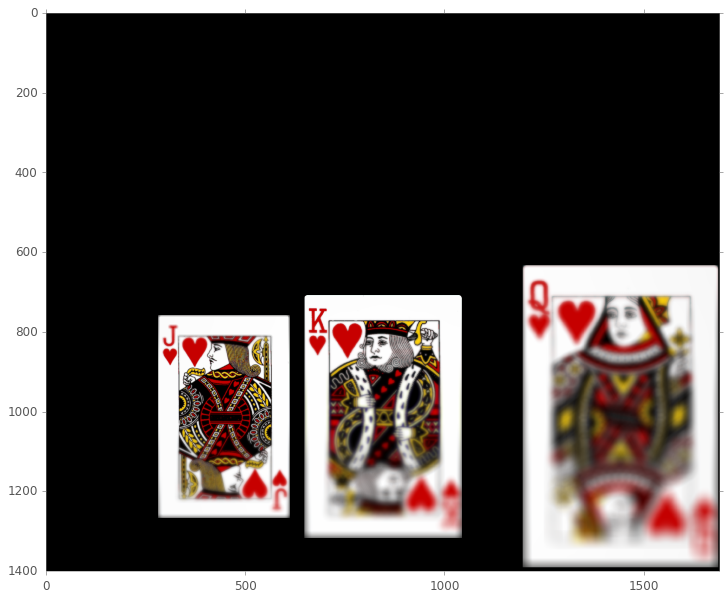

In [33]:
plt.close('all') # to close all open figures ... especially important if using %matplot notebook
oflib.iSelect = None  # Hack for now

interact(oflib.show_stack, hdffile=oflib.get_hdf5files_list(stype=1),  
         what={'Images': oflib.show_image_stack,
               'PSF Grid': oflib.show_psf_stack, 
               'CR IMG int.': oflib.show_cr_img_inter_stack,});

In [34]:
# if %matplotlib notebook backend is on 
gc.collect()
plt.close('all')

## Processing of the images in the stack for synthesizing omnifocus image

###### Perform image registration

**<font color='magenta'>To do!</font>** 

1. When I initially created the function for registering images in the stack, I used the grid of intersection points of the chief-rays with the image plane to compute the homography (instead of using the derived equation). This was convenient (at that time) because I had complete knowledge of the chief-ray intersects from Zemax (also because at that time I hadn't completely verified the analytic expressions). See the function `_get_registered_data()` in the module <kbd>`omnifocuslib`</kbd> for details. Following the registration I compared the homography (in the section [Test homography](#Test-homography)) generated by the chief-ray intersections with that obtained from the analytic equation to ensure that they are exactly the same. In future, the (inter-image) homography computation method should be changed to use the analytic expression directly. 

2. The registration function `register_data()` in the module <kbd>`omnifocuslib`</kbd>---mainly for simplicity reasons---assumes there is an image with zero tilt of the lens (i.e. in frontoparallel configuration). However, in future, this assumption should be removed. There is no need to take an image in frontoparallel configuration even if we ultimately register all images to that position.

3. If registered data is already present in the HDF5 file, the function `register_data()` does not re-register the data. There is a mechanism to prevent trying to write to the HDF5 file (which would otherwise generate a `ValueError: Unable to create group (Name already exists)`). In future, we could use a parameter (e.g. `force`) to tell the function to re-register the data. Note that I really don't forsee any reason why we would need to re-register the data since we are always going to be registering using the same closed form equation (the inter-image homography). 


In [35]:
# register the most recent data
hdffile = oflib.get_hdf5files_list()[-1]
print("HDF file :", hdffile)
imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
hdffile = os.path.join(imgdir, hdffile)

oflib.register_data(hdffile)

HDF file : lens_tilt_focal_stack_2016_03_21_02_19.hdf5
Registered data already in file. Did not re-register!


View the registered images in the stack.

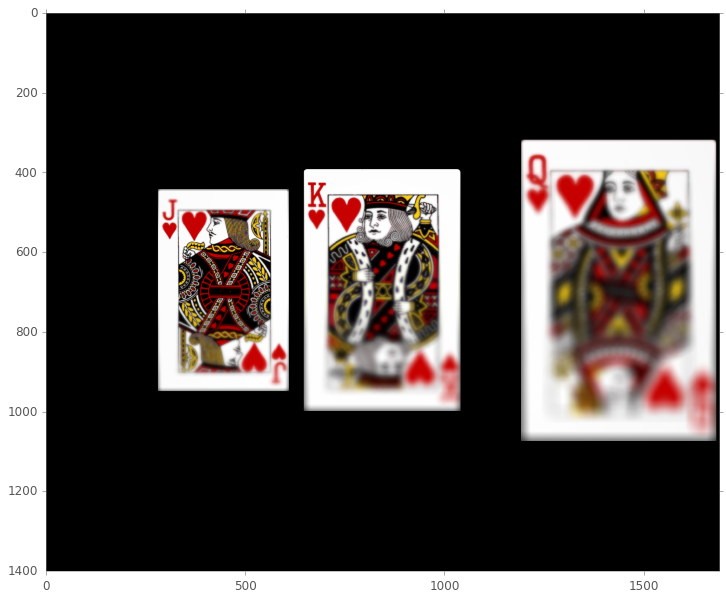

In [36]:
plt.close('all') # to close all open figures ... especially important if the notebook environment is on
oflib.iSelect = None  # Hack for now

interact(oflib.show_stack, hdffile=oflib.get_hdf5files_list(stype=1),  
         what={'Rect. Images': oflib.show_registered_image_stack,
               'Rect. PSF Grid': oflib.show_registered_psf_stack});

In [37]:
gc.collect()

3804

#### Test homography

In the following section we compare the analytic inter-image homography against that obtained from ray-tracing (based on how the point of intersections of the chief-ray with the image plane shifted between two orientations of the lens).


##### Inter-image homography obtained from Chief-ray intersects

The HDF5 file stores the inter-image homography that is used to undo the shift (and scaling) of the images. 

In [38]:
# this code cell assumes that the homography has already been estimated using CR-intersects 
# and embedded into the HDF5 file (during image registration)

tiltCnt = 0 # tiltCnt number 0 is for the extreme angle; -8° (for the particular example) 

# get the most recent HDF5 file
hdffile = oflib.get_hdf5files_list()[-1]  
imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
hdffile = os.path.join(imgdir, hdffile)

with hdf.File(hdffile, 'r') as f:
    alpha = f['data/'+'{}'.format(tiltCnt).zfill(3)].attrs['tilt_x']
    Hcr = oflib._get_homography_from_CR_intersects(f, tiltCnt)

print('\nAmount of lens tilt (in degrees) about the x-axis =', alpha)

#
print('\nInter-image homography for the 3 planes (they must be equal):')
for i in range(3):
    print('\nH({}; {}) ='.format(alpha, i+1))
    print(np.round(Hcr[:, :, i], 5))


Amount of lens tilt (in degrees) about the x-axis = -8.0

Inter-image homography for the 3 planes (they must be equal):

H(-8.0; 1) =
[[   0.99686    0.         0.     ]
 [   0.         0.99686 -625.49708]
 [   0.         0.         1.     ]]

H(-8.0; 2) =
[[   0.99686    0.         0.     ]
 [   0.         0.99686 -625.49703]
 [   0.         0.         1.     ]]

H(-8.0; 3) =
[[   0.99686    0.         0.     ]
 [   0.         0.99686 -625.49708]
 [   0.         0.         1.     ]]


##### Analytically determined shift and magnification

First, we will retrieve the necessary lens parameters required for computing the inter-image homography analytically.

In [39]:
# Set the angle of the lens to be zero before determining lens parameters
ln.zSetSurfaceParameter(surfNum=cb1, param=3, value=0)
ln.zGetUpdate()

0

In [40]:
# method 1: If the ENP, EXP surface numbers are known

enpSurfNum = 9
expSurfNum = 14

def get_vertex_distances_method1(ln, enpSurfNum, expSurfNum):
    """returns distances of the exit-pupil surface and image plane surface
    from the entrance pupil (which is the pivot point, and hence the origin of {C})
    
    @param: enpSurfNum (integer): entrance pupil surface number 
    @param: expSurfNum (integer): exit pupil surface number
    @return: d : ENPP to EXPP distance
    @return: zdasho : ENPP to IMG distance
    """
    enppGlobal = ln.zOperandValue('GLCZ', enpSurfNum)
    exppGlobal = ln.zOperandValue('GLCZ', expSurfNum)
    imgSurfNum = ln.zGetNumSurf()
    imgGlobal = ln.zOperandValue('GLCZ', imgSurfNum)
    d = exppGlobal - enppGlobal
    zdasho = imgGlobal - enppGlobal
    return d, zdasho
    
print('d = {} mm\nzoDash = {} mm'.format(*get_vertex_distances_method1(ln, enpSurfNum, expSurfNum)))

d = -8.0 mm
zoDash = 16.77628 mm


In [41]:
# method 2: Using retrieved data from the prescription

def get_vertex_distances_method2(ln):
    """returns distances of the exit-pupil surface and image plane surface
    from the entrance pupil (which is the pivot point, and hence the origin of {C})
    
    @return: d : ENPP to EXPP distance
    @return: zdasho : ENPP to IMG distance
    """
    firstSurfGlobal = ln.zOperandValue('GLCZ', 1)
    imgSurfNum = ln.zGetNumSurf()
    imgGlobal = ln.zOperandValue('GLCZ', imgSurfNum)
    pupilData = ln.zGetPupil()
    firstSurfToENPP = pupilData.ENPP
    imgSurfToEXPP = pupilData.EXPP
    firstSurfToImg = imgGlobal - firstSurfGlobal
    firstSurfToEXPP = firstSurfToImg + imgSurfToEXPP
    d = firstSurfToEXPP - firstSurfToENPP
    zdasho = firstSurfToImg - firstSurfToENPP
    return d, zdasho
    
print('d = {} mm\nzoDash = {} mm'.format(*get_vertex_distances_method2(ln)))

d = -7.99999976 mm
zoDash = 16.77628 mm


In [42]:
# We can see the both methods, as expected, gives the same values of d and zoDash

d, zoDash = get_vertex_distances_method2(ln)
print('Entrance-to-exit pupil distance, d = ', d)
print('zoDash = ', zoDash)

Entrance-to-exit pupil distance, d =  -7.99999976
zoDash =  16.77628


In [43]:
focalLength = 24
numOfImagesInStack = 13
angDelta = oflib.get_lens_plane_tilts(uo=1000, nearObj=800, farObj=1200, 
                                      fl=focalLength, num=numOfImagesInStack)
alpha = angDelta[tiltCnt] # get the angle of the tilt for the particular tilt Cnt
print('alpha = {} degrees'.format(alpha))

sfact = (d*np.cos(np.deg2rad(alpha)) - zoDash)/(d - zoDash)
print('s (magnification factor / scale factor) = ', sfact)

TO IMPLEMENT
alpha = -8.0 degrees
s (magnification factor / scale factor) =  0.996857661905


We can see that the scale factor determined analytically matches very well with diagonal elements of the inter-image homography computed using the chief-ray intersects.

In [44]:
# Now we compute the shift of the image field for that particular angle
# using the analytic expression. Note that the shift computed
shift_metric =  d*np.sin(np.deg2rad(alpha))
shift_pixels = shift_metric/detPixelSize
print('shift @ metric = ', shift_metric, ' mm')
print('shift @ pixels = ', shift_pixels)

shift @ metric =  1.11338477428  mm
shift @ pixels =  625.497064202


In [45]:
H = np.array([[sfact,      0,                 0                              ],
              [  0,      sfact,     d*np.sin(np.deg2rad(alpha))/detPixelSize ],
              [  0,       0,                  1                              ]])
H

array([[   0.99685766,    0.        ,    0.        ],
       [   0.        ,    0.99685766,  625.4970642 ],
       [   0.        ,    0.        ,    1.        ]])

In [46]:
# Close the PyZDDE link object 
if ln:
    ln.close()

## Blending the images in the stack to create omnifocus image

**<font color='magenta'>To do!</font>**

Currently, I am just dumping the registered images from the HDF5 into the directory `.\data\imgstack\png_stack` for the blending algorithm to use the images from there. In future, the algorithm should (probably) just read the images from the HDF5 file itself instead.



In [67]:
# Save registered images as png_stack
SAVE_REGISTERED_IMAGES = True

if SAVE_REGISTERED_IMAGES:
    hdffile = oflib.get_hdf5files_list()[-1]
    print('HDF File:', hdffile)
    imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
    hdffile = os.path.join(imgdir, hdffile)
    imgsavedir = os.path.join(imgdir, 'png_stack')
    # clean up the directory
    for each in os.listdir(imgsavedir):
        os.remove(os.path.join(imgsavedir,each))
    # save new images
    oflib.save_registered_images(hdffile, imgsavedir)

HDF File: lens_tilt_focal_stack_2016_03_21_02_19.hdf5
No. of images: 13
OK


Display the first image (following registration) in the stack.

In [68]:
imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
png_stack_dir = os.path.join(imgdir, 'png_stack') 

In [69]:
img = imread(png_stack_dir + '\\000.png')

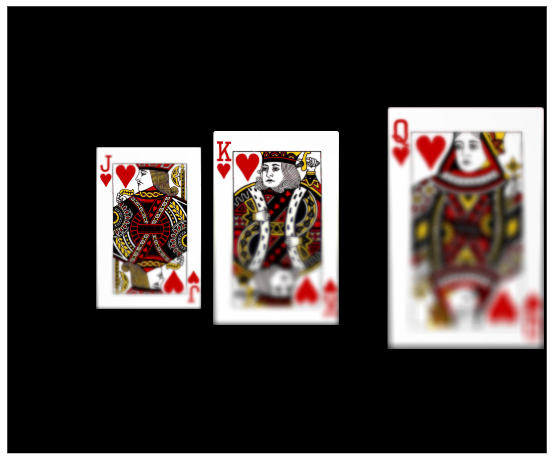

In [70]:
oflib.imshow(img, figsize=(12, 8));

In [71]:
# application of LoG or Energy of Laplacian

def focal_measure(img, method='LoG', sigma=2, morpho=0, mkern_size=5):
    """returns the focal measure within a frame
    
       @method : 'LoG', 'LoGE', 'LAP', 'LAPE'
       @sigma : standard-deviation for Gaussian filter in LoG and LoGE
       @morpho : 0=no morphological operations, 1=dilation only, 2=closing
       @mkern_size : kernel size of morphological operation
    """
    
    assert method in ('LoG', 'LoGE', 'LAP', 'LAPE'), 'Invalid method'
    
    # weights for combining the color channels
    wt_r, wt_g, wt_b = 1.0/3, 1.0/3, 1.0/3

    if method == 'LoG' or method == 'LoGE':
        _filter = ndi.gaussian_laplace
    elif method == 'LAP' or method == 'LAPE':
        _filter = ndi.laplace
    
    # Ensure that the image data type is float 64
    img = img.astype('float64')    
    
    if method == 'LoG' or method == 'LoGE':
        fm = (wt_r*np.abs(_filter(img[:,:, 0], sigma=sigma, truncate=5)) + 
              wt_g*np.abs(_filter(img[:,:, 1], sigma=sigma, truncate=5)) +
              wt_b*np.abs(_filter(img[:,:, 2], sigma=sigma, truncate=5)))
        if method == 'LoGE':
            fm = fm**2

    elif method == 'LAP' or method == 'LAPE':
        fm = (wt_r*np.abs(_filter(img[:,:, 0])) + 
              wt_g*np.abs(_filter(img[:,:, 1])) +
              wt_b*np.abs(_filter(img[:,:, 2])))
        
        if method == 'LAPE':
            fm = fm/np.max(fm)
            fm = 255*fm**2

    # Morphological operation
    morpho_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, 
                                          (mkern_size, mkern_size))
    if morpho == 1:
        fm = cv2.morphologyEx(fm, cv2.MORPH_DILATE, morpho_kernel)
    elif morpho == 2:
        fm = cv2.morphologyEx(fm, cv2.MORPH_CLOSE, morpho_kernel)
    return fm

In [72]:
morpho = 1
sigma =  2
fm_LoG = focal_measure(img, method='LoG', sigma=sigma, morpho=morpho)
fm_LoGE = focal_measure(img, method='LoGE', sigma=sigma, morpho=morpho)
fm_LAP = focal_measure(img, method='LAP', morpho=morpho)
fm_LAPE = focal_measure(img, method='LAPE', morpho=morpho)

In [73]:
def show_focal_measure(focal_measure, colormap):
    fm_dict = {'LoG': fm_LoG, 'LoGE': fm_LoGE,'LAP': fm_LAP, 'LAPE': fm_LAPE}
    cmap_dict ={'magma': plt.cm.magma, 'virdis': plt.cm.viridis, 'plasma':plt.cm.plasma}
    img = fm_dict[focal_measure]
    if focal_measure == 'LoG':  # only for display purpose
        img = img**1.5
    oflib.imshow(image=img, figsize=(13, 9),  
              cmap=cmap_dict[colormap]);

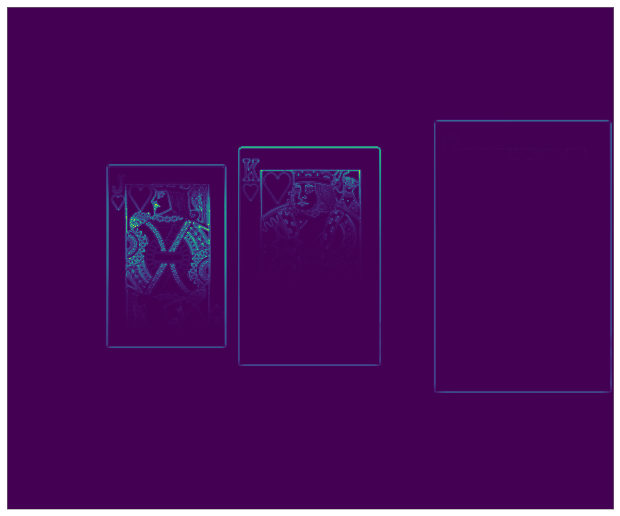

In [75]:
# display focal measures
v = interactive(show_focal_measure, 
                focal_measure=('LoG', 'LoGE', 'LAP', 'LAPE'), 
                colormap=('magma', 'virdis', 'plasma'))
display.display(v)

In [76]:
gc.collect()

16437

In [77]:
# create stack and  (assumes that the images are already aligned)
# currently the the registered images are being collected from the png_stack folder
# TODO: the input data could also be from the registered arrays in the HDF file

gc.collect()
imgdir = os.path.join(os.getcwd(), 'data', 'imgstack')
png_stack_dir = os.path.join(imgdir, 'png_stack')
imglist = oflib.get_imlist(filePath=png_stack_dir, itype='png')

#morpho = 1
#sigma = 2
#method = 'LAP'
#method = 'LoG'
method = 'LoGE'

# create focal_measure stack
img_rgb_stack = [imread(image) for image in imglist]  # to do ... memory map to HDF file
fm_measure_stack = [focal_measure(img, method, sigma, morpho) for img in img_rgb_stack]
fm_measure_stack = np.dstack(fm_measure_stack)

In [79]:
# create composite
composite_img = np.zeros_like(img_rgb_stack[0])
fm_max_indices = np.argmax(fm_measure_stack, axis=2)
for index in range(len(imglist)):
    mask = fm_max_indices==index
    composite_img[:, :, 0] = composite_img[:, :, 0] + img_rgb_stack[index][:,:,0]*mask   
    composite_img[:, :, 1] = composite_img[:, :, 1] + img_rgb_stack[index][:,:,1]*mask   
    composite_img[:, :, 2] = composite_img[:, :, 2] + img_rgb_stack[index][:,:,2]*mask  

The following figure shows origin (from which image number in the stack) of every pixel in the composite image. 

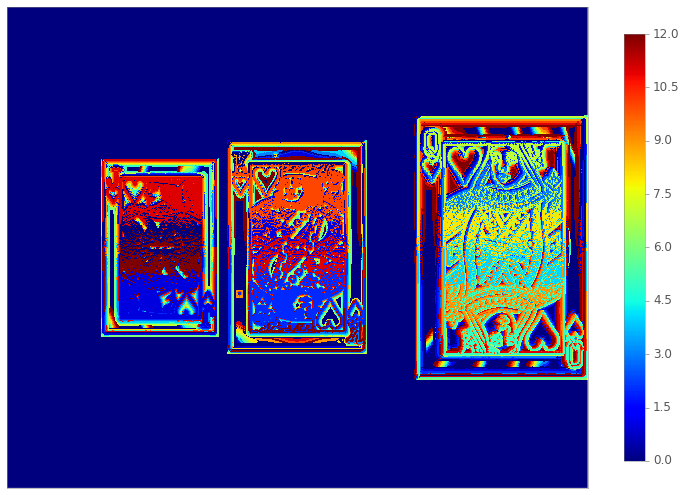

In [80]:
# show max_indices map
cmap = plt.get_cmap(name=plt.cm.jet, lut=len(imglist))
#img, fig, ax = oflib.imshow(image=(fm_max_indices==0), figsize=(13, 9), cmap=cmap, interpol='none')
img, fig, ax = oflib.imshow(image=fm_max_indices, figsize=(13, 9), cmap=cmap, interpol='none')
plt.colorbar(shrink=0.85);

###### Composite image

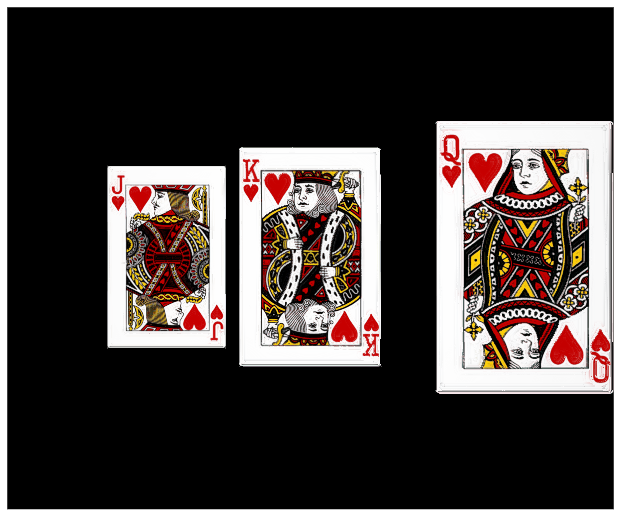

In [81]:
oflib.imshow(image=composite_img, figsize=(13, 9));

**<font color='magenta'>To do!</font>**

The process selecting pixels across the images in the stack should be improved. There are many algorithms; however, since this part was not the main focus of this paper, I have currently implemented a very simple algorithm to blend the images. Therefore, we can see few artifacts around the edges of the three planes. 

In [82]:
gc.collect()

3201

###### Focal measure of composite image

In [83]:
# focal measure of the composite image
fm_composite_LoG = focal_measure(composite_img, method='LoG', sigma=sigma, morpho=morpho)

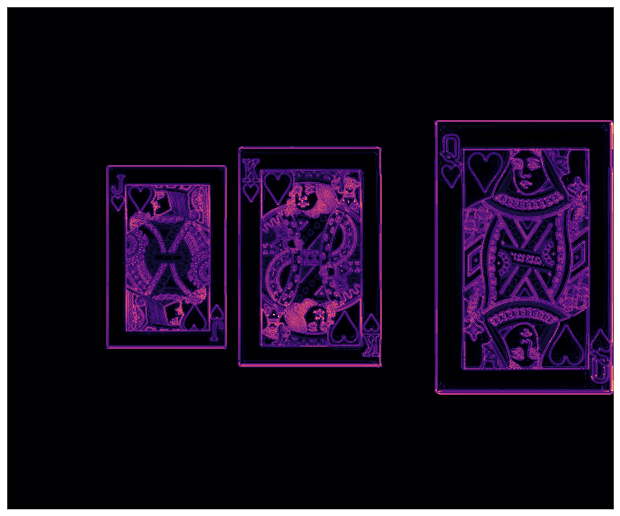

In [84]:
oflib.imshow(image=fm_composite_LoG, figsize=(13, 9), cmap='magma');

In [85]:
gc.collect()

3159

In the above figure, which shows the focus measure of the composite image, we see that all three cards are in focus.

In [4]:
from IPython.core.display import HTML
import urllib2
def css_styling():
    url = 'https://raw.githubusercontent.com/indranilsinharoy/python_env_stylefiles/master/custom.css'
    styles = urllib2.urlopen(url).read()
    return HTML(styles)
css_styling();